## Download and clean data

In [3]:
# Data tools
import pandas as pd
import numpy as np
from numba import jit 
from binance.client import Client
from scipy.stats import norm

# Visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
binance = BinanceAPI()

In [3]:
## Download the data
# binance.minute_bar(symbol='BTCUSDT',begin = '1 Jan 2018', end='1 Jan 2023')

In [4]:
df = pd.read_parquet('./data/BTCUSDT_1Min.parq')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2621433 entries, 2018-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   open    object
 1   high    object
 2   low     object
 3   close   object
 4   volume  object
dtypes: object(5)
memory usage: 120.0+ MB


In [5]:
# Specify column to convert
columns_to_convert = ['open', 'high', 'low', 'close', 'volume']

# Convert specified columns to float64
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Verify the data types after conversion
print(df.dtypes)


open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


Create a `normal_test` function to visualize normal dist of the rets

In [6]:
def normal_test(df,column):
    df['Returns'] = np.log(df[f'{column}']).diff()
    df.dropna(inplace=True)
    # Plot the return histogram
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    df['Returns'].hist(bins=50, ax=ax1)
    ax1.set_xlabel('Return')
    ax1.set_ylabel('Count')
    ax1.set_title('Return distribution')

    # Plot the normal distribution
    mu = df['Returns'].mean()
    sigma = df['Returns'].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma))
    return plt.show()
    

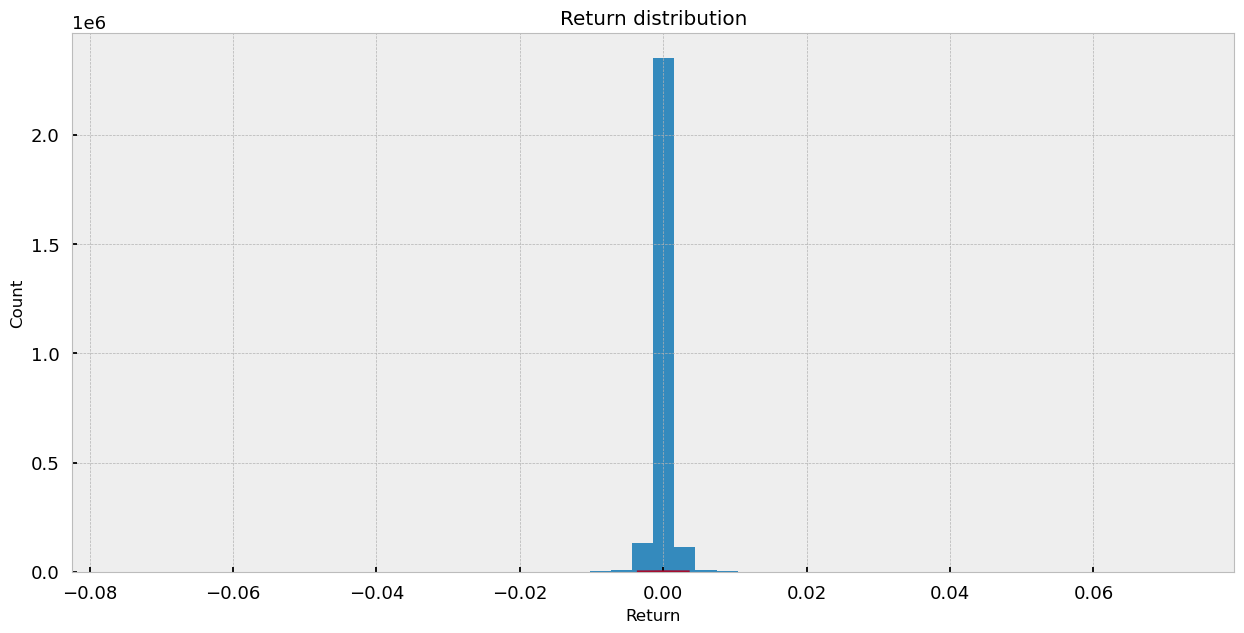

In [7]:
normal_test(df,'close')

The returns of minute bar is absolutely not normal

In [10]:
# Volume tick
df['v'] = df['volume']
# Dollar value tick
df['dv'] = df['volume']*df['close']
df.head()

,open,high,low,close,volume,v,dv
timestamp,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13681.00,13707.92,2.844266,2.844266,38988.970787
2018-01-01 00:01:00,13707.91,13707.91,13666.11,13694.92,2.113138,2.113138,28939.255859
2018-01-01 00:02:00,13682.00,13694.94,13680.00,13680.00,1.346411,1.346411,18418.902480
2018-01-01 00:03:00,13679.98,13679.98,13601.00,13645.99,11.589417,11.589417,158149.068488
2018-01-01 00:04:00,13645.98,13646.00,13576.28,13600.00,15.724566,15.724566,213854.097600


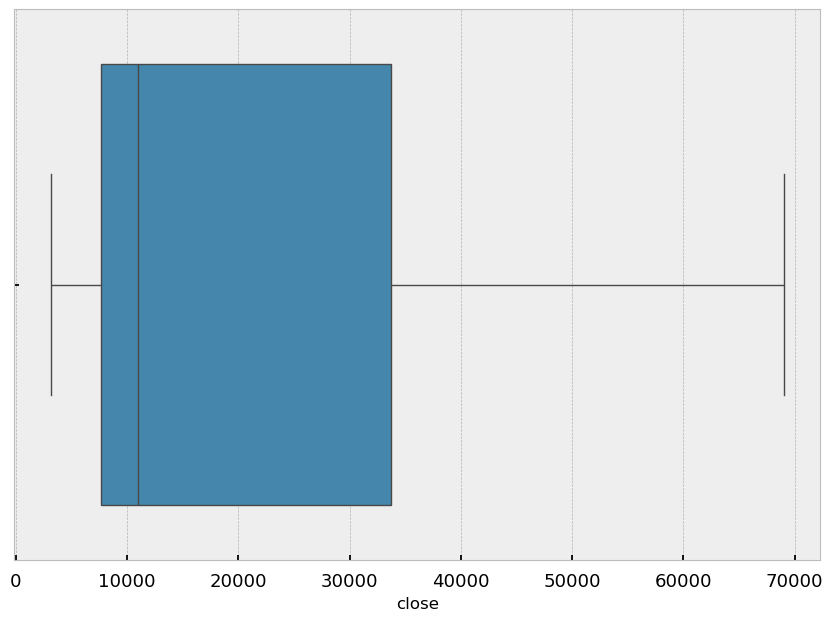

In [9]:
# Visualize the anormallies
sns.boxplot(df.close, orient='h');

---

## Create Tick Bars

The function `tick_bars` simply find the column index of the trade where the price reaches a certain threatshold m

In [10]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

In [11]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 2,621,432
volume ratio: 51.0
dollar ratio: 1090065.0


It means for each time the price goes up $100, there is 1 tick

In [20]:
tick_M = 100 # arbitrary
print(f'tick threshold: {tick_M:,}')
tidx = tick_bars(df, 'close', tick_M)
tidx[:10]

tick threshold: 100


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [23]:
df.iloc[tidx].shape, df.shape

((26214, 8), (2621432, 8))

In [24]:
tick_df = tick_bar_df(df, 'close', tick_M)
tick_df.shape

(26214, 8)

In [25]:
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
xDate ='2019-10-09' #'2017-10-4'
xdf, xtdf = select_sample_data(df, tick_df, 'close', xDate)

xdf.shape, xtdf.shape


((1440,), (15,))

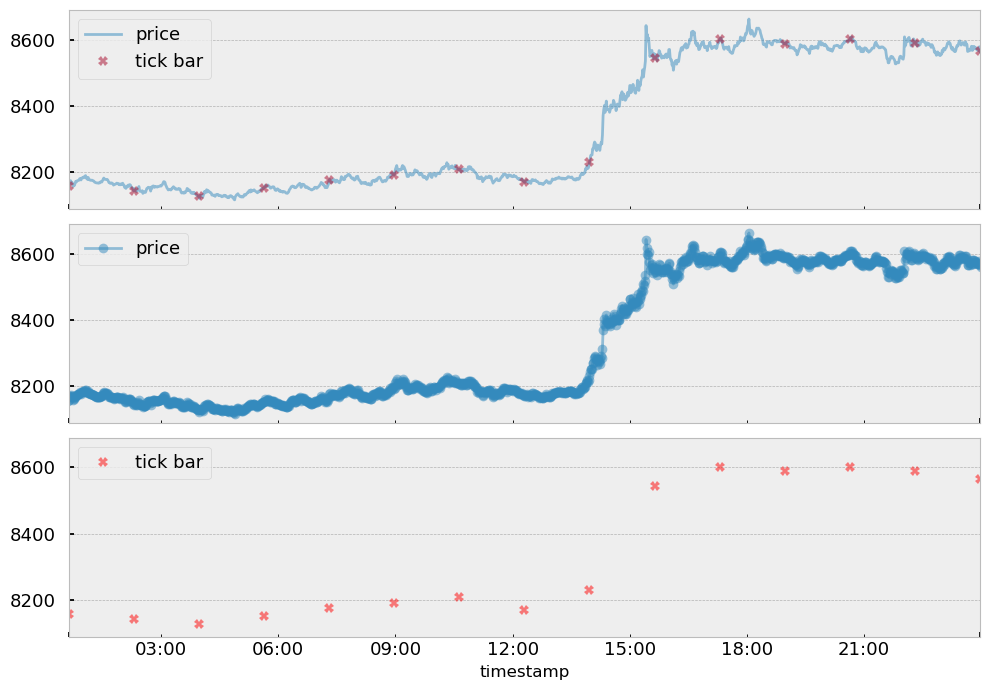

In [26]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

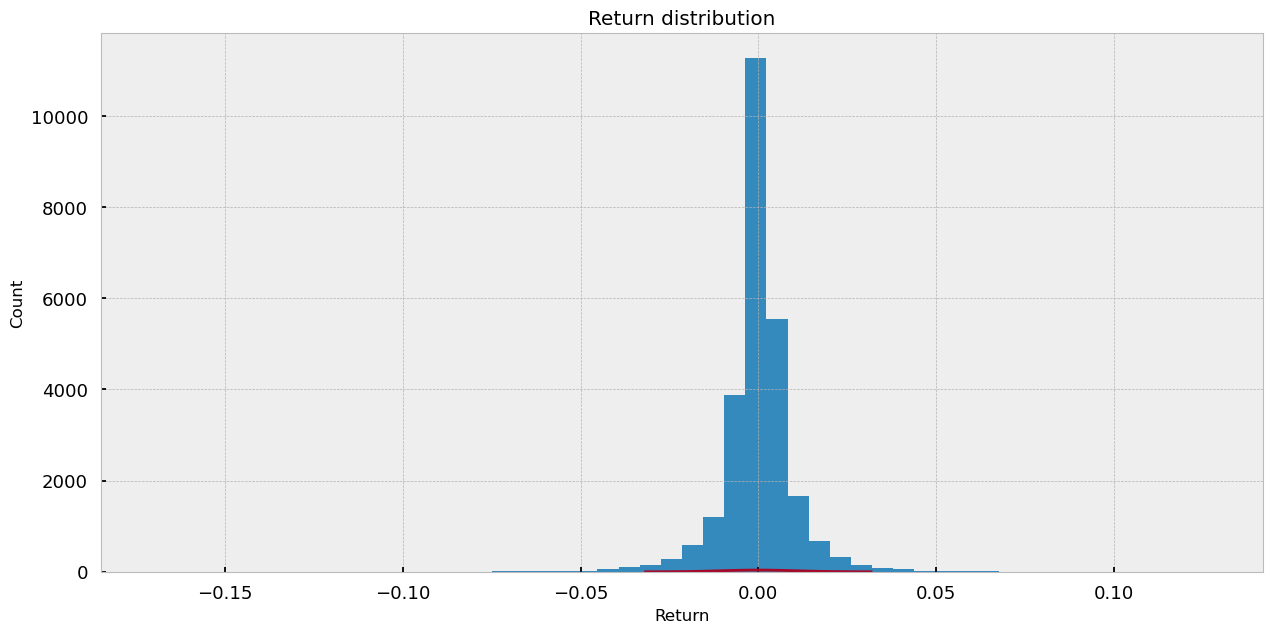

In [27]:
normal_test(tick_df,'close')

The volume bar indicate if the total trading volume reaches a threatshold v

In [44]:
# Create volume bar
def volume_bars(df, volume_column, v):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        v: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= v:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, v):
    idx = volume_bars(df, volume_column, v)
    return df.iloc[idx].drop_duplicates()

In [48]:
volume_M =  10_000 # arbitrary 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(df, 'v', volume_M)
v_bar_df.head()

volume threshold: 10,000


,open,high,low,close,volume,Returns,v,dv
timestamp,,,,,,,,
2018-01-02 02:27:00,13503.90,13537.89,13465.88,13490.84,16.176328,-0.000968,16.176328,218232.252836
2018-01-02 16:05:00,13752.02,13776.00,13752.02,13774.99,16.836159,0.001669,16.836159,231917.921863
2018-01-03 01:50:00,14815.05,14819.84,14804.05,14813.98,15.942483,0.000671,15.942483,236171.624312
2018-01-03 13:00:00,14469.00,14469.00,14421.33,14448.54,4.469853,-0.000101,4.469853,64582.849865
2018-01-04 07:34:00,14730.98,14730.99,14709.61,14730.00,14.173780,-0.000067,14.173780,208779.779400


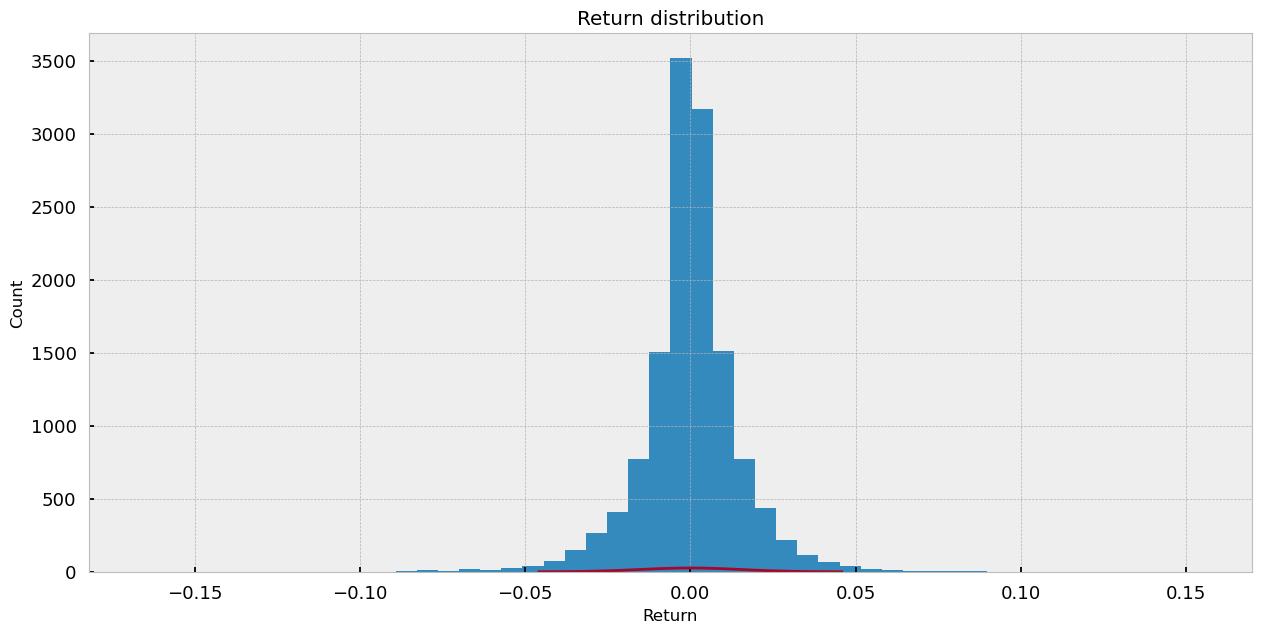

In [49]:
normal_test(v_bar_df,'close')

xdf shape: (1440,), xtdf shape: (4,)


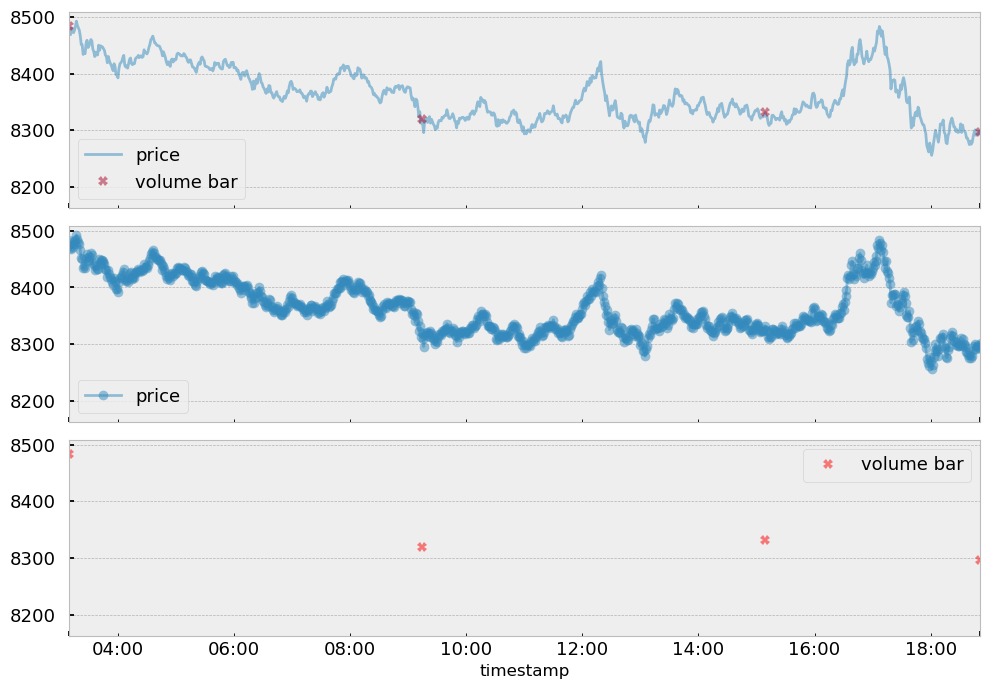

In [50]:
xDate = '2019-10-1'
xdf, xtdf = select_sample_data(df, v_bar_df, 'close', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'volume bar', alpha=0.5, markersize=7)  

The dollar value bar means each time the total traded value reaches a threatshold, its one tick

In [58]:
def dollar_bars(df, dv_column, d):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        d: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= d:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, d):
    idx = dollar_bars(df, dv_column, d)
    return df.iloc[idx].drop_duplicates()


In [83]:
dollar_M = 10_000_000 # arbitrary 
print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
dv_bar_df.head()

dollar threshold: 10,000,000


,open,high,low,close,volume,Returns,v,dv
timestamp,,,,,,,,
2018-01-01 01:52:00,13369.99,13380.00,13343.03,13346.44,6.891834,-0.002511,6.891834,91981.448971
2018-01-01 03:34:00,13600.01,13611.01,13567.14,13589.98,8.213691,-0.000738,8.213691,111623.896416
2018-01-01 05:18:00,13632.00,13688.03,13620.01,13667.00,10.534791,0.002564,10.534791,143978.988597
2018-01-01 07:59:00,13590.76,13600.00,13555.02,13570.35,6.226006,-0.001096,6.226006,84489.080522
2018-01-01 11:08:00,13361.44,13361.44,13240.87,13240.90,15.010377,-0.009062,15.010377,198750.900819


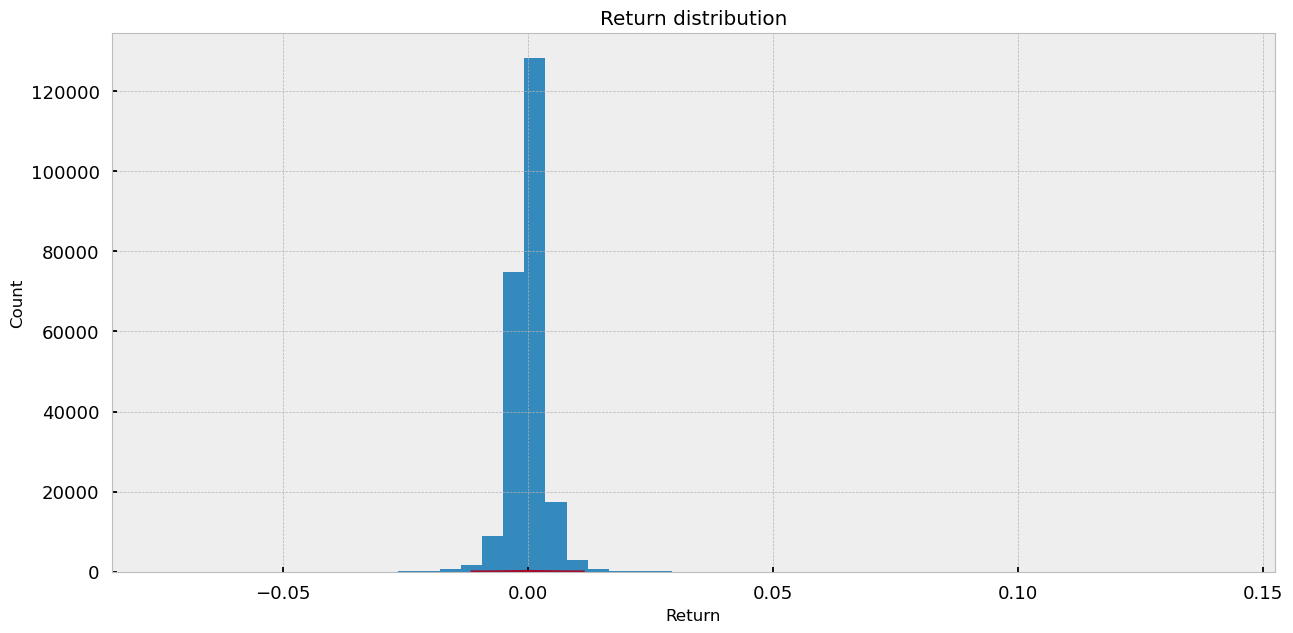

In [84]:
normal_test(dv_bar_df,'close')

xdf shape: (1440,), xtdf shape: (35,)


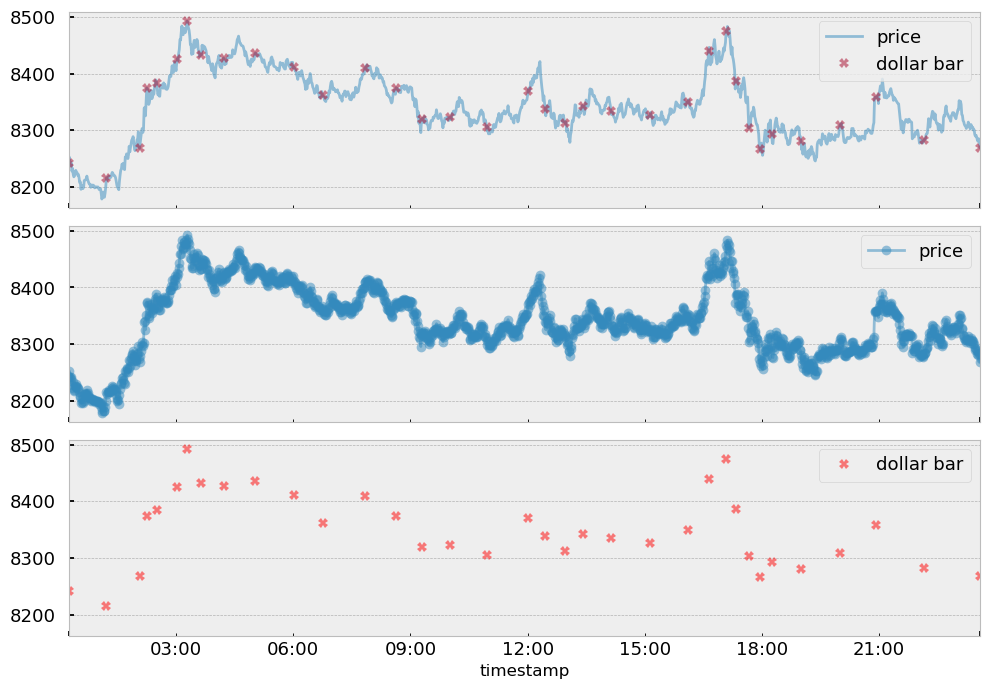

In [85]:
xDate = '2019-10-1'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'close', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7)  

In [1]:
from tickcomp import TickBar

In [7]:
data = TickBar(df)

In [11]:
dollar_test = data.dollar_tick(100)
dollar_test

,open,high,low,close,volume,v,dv
timestamp,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13681.00,13707.92,2.844266,2.844266,3.898897e+04
2018-01-01 00:01:00,13707.91,13707.91,13666.11,13694.92,2.113138,2.113138,2.893926e+04
2018-01-01 00:02:00,13682.00,13694.94,13680.00,13680.00,1.346411,1.346411,1.841890e+04
2018-01-01 00:03:00,13679.98,13679.98,13601.00,13645.99,11.589417,11.589417,1.581491e+05
2018-01-01 00:04:00,13645.98,13646.00,13576.28,13600.00,15.724566,15.724566,2.138541e+05
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.588400,38.588400,6.382722e+05
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.359780,53.359780,8.824523e+05
2022-12-31 23:58:00,16537.78,16538.81,16536.42,16536.42,28.882390,28.882390,4.776113e+05


In [12]:
# Download the data
binance.minute_bar(symbol='BNBUSDT',begin = '1 Jan 2018', end='1 Jan 2023')
binance.minute_bar(symbol='ETHUSDT',begin = '1 Jan 2018', end='1 Jan 2023')
binance.minute_bar(symbol='SOLUSDT',begin = '1 Jan 2018', end='1 Jan 2023')
binance.minute_bar(symbol='XRPUSDT',begin = '1 Jan 2018', end='1 Jan 2023')

Downloading...
Completed!
Downloading...
Completed!
Downloading...
Completed!
Downloading...
Completed!


In [8]:
# Load data to the data frame
btc_1min = pd.read_parquet('./data/BTCUSDT_1Min.parq').astype('float')
bnb_1min = pd.read_parquet('./data/BNBUSDT_1Min.parq').astype('float')
eth_1min = pd.read_parquet('./data/ETHUSDT_1Min.parq').astype('float')
sol_1min = pd.read_parquet('./data/SOLUSDT_1Min.parq').astype('float')
xrp_1min = pd.read_parquet('./data/XRPUSDT_1Min.parq').astype('float')

In [9]:
def compute_v_dv(df):
    df['v'] = df['volume']
    df['dv'] = df['volume'] * df['close']
    return df

# Adding column for the TickBar function
btc_1min = compute_v_dv(btc_1min)
bnb_1min = compute_v_dv(bnb_1min)
eth_1min = compute_v_dv(eth_1min)
sol_1min = compute_v_dv(sol_1min)
xrp_1min = compute_v_dv(xrp_1min)

In [5]:
data = pd.read_csv('../data/BTCUSD_15min.csv')
data.head()

,date,open,high,low,close,volume
0,2023-11-18 00:00:00,36405.00,36405.0,36320.80,36325.74,1.468335e+06
1,2023-11-18 00:15:00,36325.75,36372.0,36325.75,36339.03,1.649893e+06
2,2023-11-18 00:30:00,36355.10,36389.0,36339.28,36377.45,9.380177e+05
3,2023-11-18 00:45:00,36377.44,36388.0,36336.02,36349.24,1.444831e+06
4,2023-11-18 01:00:00,36355.60,36387.0,36333.70,36370.18,2.335101e+06


In [1]:
from openbb import obb

from src.config import Settings

In [1]:
import sys
sys.path.append("/Users/baobach/Algo-Trading-Binance")
from src.historical import BinanceAPI

In [5]:
apis = BinanceAPI()
data = apis.download_15m(symbol='BTCUSDT', begin = '1 Jan 2020', end = '1 Jan 2024')

Downloading...
Completed!


In [4]:
data.to_csv('../data/BTCUSDT_15min.csv')